# Galaxy Wearables vs Nurse Stress - Porównanie Trendów Stresu

## Cel:
Porównanie trendów stresu między:
- **Galaxy Wearables** (dane laboratoryjne: baseline vs TSST/SSST)
- **Nurse Stress** (dane z realnego miejsca pracy: baseline vs stres)

## Metodologia:
1. **Wspólne cechy**: RMSSD, SDNN/SDRR, pNN50, HR_mean, ACC_mean, ACC_energy, TEMP_mean
2. **Porównanie trendowe**: baseline vs stres (zmiany procentowe)
3. **Wizualizacje**: bar chart, radar chart, heatmapa zmian względnych
4. **Korelacje trendów**: Pearson/Spearman między zmianami cech w obu datasetach

## ⚠️ WAŻNE:
- Porównanie jest **trendowe/statystyczne**, nie osobowe
- Nie synchronizujemy czasowo - porównujemy średnie zmiany
- Fokus na **podobieństwie kierunku zmian**, nie wartości bezwzględnych
- **Galaxy = stres chwilowy** (laboratoryjny, TSST/SSST)
- **Nurse = stres chroniczny** (realne miejsce pracy, przewlekły)
- Porównujemy **trendy**, nie wartości bezwzględne - różnice w amplitudzie i przewlekłości są oczekiwane


## KROK 1: Import bibliotek i konfiguracja


In [237]:
# 🔹 IMPORTS I KONFIGURACJA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Ustawienia
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Style wizualizacji
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ścieżki do danych
# Galaxy: wczytaj z CSV (utworzonego po segmentacji w galaxy_wearables_stress_analysis.ipynb)
GALAXY_DATA_PATH = Path("../results/galaxy_segments.csv")  # Możesz zmienić na właściwą ścieżkę
# Alternatywnie: jeśli dane są zapisane w innym miejscu, zaktualizuj ścieżkę

# Nurse: wczytaj z CSV
NURSE_DATA_PATH = Path("../nurse-stress-analysis/results/nurse_physiological_features.csv")

# Katalog wyników
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print("✅ Importy zakończone")
print(f"   Ścieżka do danych Galaxy: {GALAXY_DATA_PATH}")
print(f"   Ścieżka do danych Nurse: {NURSE_DATA_PATH}")
print(f"   Katalog wyników: {RESULTS_DIR}")


✅ Importy zakończone
   Ścieżka do danych Galaxy: ../results/galaxy_segments.csv
   Ścieżka do danych Nurse: ../nurse-stress-analysis/results/nurse_physiological_features.csv
   Katalog wyników: ../results


## KROK 2: Wczytanie danych Galaxy Wearables


In [238]:
# 🔹 WCZYTYWANIE DANYCH GALAXY WEARABLES
print(f"{'='*80}")
print(f"KROK 2: WCZYTYWANIE DANYCH GALAXY WEARABLES")
print(f"{'='*80}")

# Sprawdź czy dane są dostępne w globals (z galaxy_wearables_stress_analysis.ipynb)
if 'df_all' in globals() and df_all is not None and not df_all.empty:
    df_galaxy = df_all.copy()
    print(f"✅ Wczytano dane Galaxy z globals: {df_galaxy.shape}")
else:
    # Wczytaj z CSV - spróbuj kilku możliwych ścieżek
    possible_paths = [
        Path("../results/galaxy_segments.csv"),
        Path("galaxy_segments.csv"),
        Path("../galaxy_segments.csv"),
        GALAXY_DATA_PATH  # Z konfiguracji
    ]
    
    df_galaxy = None
    for csv_path in possible_paths:
        if csv_path.exists():
            try:
                df_galaxy = pd.read_csv(csv_path)
                print(f"✅ Wczytano dane Galaxy z CSV: {csv_path}")
                print(f"   Shape: {df_galaxy.shape}")
                break
            except Exception as e:
                print(f"⚠️ Błąd wczytywania {csv_path}: {e}")
                continue
    
    if df_galaxy is None:
        print(f"\n⚠️ Nie znaleziono danych Galaxy w żadnej z ścieżek:")
        for p in possible_paths:
            print(f"   - {p} ({'ISTNIEJE' if p.exists() else 'NIE ISTNIEJE'})")
        print(f"\n💡 Rozwiązanie:")
        print(f"   1. Uruchom komórkę 12 z galaxy_wearables_stress_analysis.ipynb")
        print(f"      (teraz automatycznie zapisze do ../results/galaxy_segments.csv)")
        print(f"   2. Lub ręcznie zapisz: df_all.to_csv('../results/galaxy_segments.csv', index=False)")
        print(f"   3. Lub ustaw GALAXY_DATA_PATH w komórce 1 na właściwą ścieżkę")
        df_galaxy = None

if df_galaxy is not None:
    print(f"\n📊 Struktura danych Galaxy:")
    print(f"   Shape: {df_galaxy.shape}")
    print(f"   Kolumny ({len(df_galaxy.columns)}): {list(df_galaxy.columns)[:15]}...")
    
    # Sprawdź rozkład etykiet
    if 'label' in df_galaxy.columns:
        print(f"\n   Rozkład etykiet:")
        label_counts = df_galaxy['label'].value_counts()
        for label, count in label_counts.items():
            print(f"      {label}: {count} segmentów ({count/len(df_galaxy)*100:.1f}%)")
    
    # Sprawdź dostępne cechy HRV
    hrv_features = [col for col in df_galaxy.columns if any(x in col.upper() for x in ['RMSSD', 'SDNN', 'SDRR', 'PNN50', 'MEAN_RR', 'HR'])]
    print(f"\n   Dostępne cechy HRV: {hrv_features[:10]}")
    
    # Sprawdź dostępne cechy ACC
    acc_features = [col for col in df_galaxy.columns if 'ACC' in col.upper()]
    print(f"   Dostępne cechy ACC: {acc_features[:10]}")
    
    # Sprawdź dostępne cechy TEMP
    temp_features = [col for col in df_galaxy.columns if 'TEMP' in col.upper()]
    print(f"   Dostępne cechy TEMP: {temp_features[:10]}")
    
    # Sprawdź dostępne cechy EDA
    eda_features = [col for col in df_galaxy.columns if 'EDA' in col.upper()]
    print(f"   Dostępne cechy EDA: {eda_features[:10] if eda_features else 'BRAK'}")


KROK 2: WCZYTYWANIE DANYCH GALAXY WEARABLES
✅ Wczytano dane Galaxy z CSV: ../results/galaxy_segments.csv
   Shape: (1044, 38)

📊 Struktura danych Galaxy:
   Shape: (1044, 38)
   Kolumny (38): ['participant_id', 'datasetId', 'session_name', 'label', 'window_idx', 'window_start_unix', 'window_end_unix', 'MEAN_RR', 'SDRR', 'RMSSD', 'pNN50', 'HR', 'VLF', 'LF', 'HF']...

   Rozkład etykiet:
      no stress: 565 segmentów (54.1%)
      stress: 479 segmentów (45.9%)

   Dostępne cechy HRV: ['MEAN_RR', 'SDRR', 'RMSSD', 'pNN50', 'HR']
   Dostępne cechy ACC: ['ACC_mean', 'ACC_std', 'ACC_min', 'ACC_max', 'ACC_energy']
   Dostępne cechy TEMP: ['TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max']
   Dostępne cechy EDA: BRAK


## KROK 3: Wczytanie danych Nurse Stress


In [239]:
# 🔹 WCZYTYWANIE DANYCH NURSE STRESS
print(f"{'='*80}")
print(f"KROK 3: WCZYTYWANIE DANYCH NURSE STRESS")
print(f"{'='*80}")

if NURSE_DATA_PATH.exists():
    df_nurse = pd.read_csv(NURSE_DATA_PATH)
    print(f"✅ Wczytano dane Nurse z CSV: {df_nurse.shape}")
    print(f"   Kolumny ({len(df_nurse.columns)}): {list(df_nurse.columns)[:20]}...")
    
    # Sprawdź rozkład etykiet (może być w kolumnie 'label' lub innej)
    label_col = None
    for col in ['label', 'Label', 'condition', 'Condition', 'stress', 'Stress']:
        if col in df_nurse.columns:
            label_col = col
            break
    
    if label_col:
        print(f"\n   Rozkład etykiet (kolumna '{label_col}'):")
        label_counts = df_nurse[label_col].value_counts()
        for label, count in label_counts.items():
            print(f"      {label}: {count} segmentów ({count/len(df_nurse)*100:.1f}%)")
        # Zmień nazwę kolumny na 'label' dla spójności
        if label_col != 'label':
            df_nurse['label'] = df_nurse[label_col]
    else:
        print("\n   ⚠️ Nie znaleziono kolumny z etykietami. Sprawdzam strukturę...")
        print(f"   Dostępne kolumny: {list(df_nurse.columns)[:10]}")
    
    # Sprawdź dostępne cechy HRV
    hrv_features_nurse = [col for col in df_nurse.columns if any(x in col.upper() for x in ['RMSSD', 'SDNN', 'SDRR', 'PNN50', 'MEAN_RR', 'HR'])]
    print(f"\n   Dostępne cechy HRV: {hrv_features_nurse[:10]}")
    
    # Sprawdź dostępne cechy ACC (może nie być)
    acc_features_nurse = [col for col in df_nurse.columns if 'ACC' in col.upper()]
    print(f"   Dostępne cechy ACC: {acc_features_nurse[:10] if acc_features_nurse else 'BRAK'}")
    
    # Sprawdź dostępne cechy TEMP
    temp_features_nurse = [col for col in df_nurse.columns if 'TEMP' in col.upper()]
    print(f"   Dostępne cechy TEMP: {temp_features_nurse[:10]}")
    
    # Sprawdź dostępne cechy EDA
    eda_features_nurse = [col for col in df_nurse.columns if 'EDA' in col.upper()]
    print(f"   Dostępne cechy EDA: {eda_features_nurse[:10] if eda_features_nurse else 'BRAK'}")
else:
    print(f"❌ Nie znaleziono danych Nurse w: {NURSE_DATA_PATH}")
    print(f"   Sprawdź ścieżkę do danych Nurse Stress")
    df_nurse = None


KROK 3: WCZYTYWANIE DANYCH NURSE STRESS
✅ Wczytano dane Nurse z CSV: (3, 50)
   Kolumny (50): ['id', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_skew', 'EDA_kurtosis', 'EDA_auc', 'EDA_slope', 'EDA_tonic_level', 'EDA_n_peaks', 'EDA_latency', 'EDA_reaction_duration', 'EDA_peak_mean_amplitude', 'EDA_mean_peak_interval', 'EDA_std_peak_interval', 'EDA_n_scr', 'EDA_scr_mean_amplitude', 'EDA_scr_mean_rise_time', 'EDA_scr_mean_recovery_time']...

   ⚠️ Nie znaleziono kolumny z etykietami. Sprawdzam strukturę...
   Dostępne kolumny: ['id', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_skew', 'EDA_kurtosis', 'EDA_auc', 'EDA_slope', 'EDA_tonic_level']

   Dostępne cechy HRV: ['HR_mean', 'HR_std', 'HR_min', 'HR_max', 'HR_skew', 'HR_kurtosis', 'HR_auc', 'HR_slope', 'HR_n_peaks', 'HR_latency']
   Dostępne cechy ACC: BRAK
   Dostępne cechy TEMP: ['TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max', 'TEMP_skew', 'TEMP_kurtosis', 'TEMP_auc', 'TEMP_slope', 'TEMP_n_peaks', 'TEMP_latency']
   Dostęp

## KROK 4: Wybór wspólnych cech i przygotowanie danych


In [240]:
# 🔹 WYBÓR WSPÓLNYCH CECH I PRZYGOTOWANIE DANYCH
print(f"{'='*80}")
print(f"KROK 4: WYBÓR WSPÓLNYCH CECH")
print(f"{'='*80}")

if df_galaxy is None or df_nurse is None:
    print("❌ Brak danych Galaxy lub Nurse. Uruchom najpierw komórki 2 i 3.")
else:
    # 1️⃣ NAJPIERW: Znajdź wspólne cechy jako przecięcie kolumn (automatyczne)
    print(f"\n🔹 KROK 1: Automatyczne wyszukiwanie wspólnych cech jako przecięcie kolumn")
    
    # Usuń metadane z listy kolumn (tylko cechy)
    metadata_cols = ['id', 'participant_id', 'subject', 'subject_id', 'dataset', 'dataset_id',
                     'window_idx', 'window_start', 'window_end', 'window_start_unix', 'window_end_unix',
                     'session', 'session_name', 'segment', 'timestamp', 'datetime', 'date',
                     'X', 'Y', 'Z',  # Surowe dane ACC (używamy obliczonych cech)
                     'label', 'Label', 'condition', 'Condition', 'stress', 'Stress']  # Etykiety - nie są cechami
    
    galaxy_feature_cols = [col for col in df_galaxy.columns if col not in metadata_cols]
    nurse_feature_cols = [col for col in df_nurse.columns if col not in metadata_cols]
    
    print(f"   Galaxy: {len(galaxy_feature_cols)} cech (po usunięciu metadanych)")
    print(f"   Nurse: {len(nurse_feature_cols)} cech (po usunięciu metadanych)")
    
    # Znajdź przecięcie (wspólne nazwy kolumn)
    common_cols_auto = list(set(galaxy_feature_cols) & set(nurse_feature_cols))
    print(f"\n   ✅ Automatycznie znaleziono {len(common_cols_auto)} wspólnych cech (identyczne nazwy)")
    if len(common_cols_auto) > 0:
        print(f"      Przykłady: {common_cols_auto[:10]}")
    
    # 2️⃣ DODATKOWO: Elastyczne mapowanie dla cech o różnych nazwach
    print(f"\n🔹 KROK 2: Elastyczne mapowanie cech o różnych nazwach")
    # Definicja wspólnych cech (nazwy mogą się różnić, więc szukamy podobnych)
    # Elastyczne mapowanie - różne nazwy w różnych datasetach
    # ROZSZERZONE: HRV, TEMP, EDA features
    common_features_map = {
        # HRV features - podstawowe statystyki
        'HR_mean': {
            'galaxy': ['HR', 'hr', 'HR_mean', 'MEAN_HR', 'mean_hr', 'HRV_HR'],
            'nurse': ['HR_mean', 'HR', 'hr', 'mean_hr']
        },
        'HR_std': {
            'galaxy': ['HR_std', 'hr_std', 'HR_STD', 'HRV_HR_std'],
            'nurse': ['HR_std', 'HR_std', 'hr_std']
        },
        'HR_min': {
            'galaxy': ['HR_min', 'hr_min', 'HR_MIN', 'HRV_HR_min'],
            'nurse': ['HR_min', 'HR_min', 'hr_min']
        },
        'HR_max': {
            'galaxy': ['HR_max', 'hr_max', 'HR_MAX', 'HRV_HR_max'],
            'nurse': ['HR_max', 'HR_max', 'hr_max']
        },
        
        # HRV features - zaawansowane (jeśli dostępne)
        'RMSSD': {
            'galaxy': ['RMSSD', 'rmssd', 'HRV_RMSSD'],
            'nurse': ['HR_rmssd', 'RMSSD', 'rmssd', 'HRV_RMSSD']
        },
        'SDNN': {
            'galaxy': ['SDNN', 'sdnn', 'SDRR', 'sdrr', 'HRV_SDNN'],
            'nurse': ['HR_std', 'SDNN', 'sdnn', 'SDRR', 'sdrr']  # SDNN może być przybliżone przez HR_std
        },
        'pNN50': {
            'galaxy': ['pNN50', 'pnn50', 'PNN50', 'HRV_pNN50'],
            'nurse': []  # Może nie być dostępne
        },
        
        # TEMP features - podstawowe statystyki
        'TEMP_mean': {
            'galaxy': ['TEMP_mean', 'temp_mean', 'TEMP_MEAN', 'temperature_mean'],
            'nurse': ['TEMP_mean', 'temp_mean', 'TEMP', 'temp']
        },
        'TEMP_std': {
            'galaxy': ['TEMP_std', 'temp_std', 'TEMP_STD', 'temperature_std'],
            'nurse': ['TEMP_std', 'temp_std', 'TEMP_std']
        },
        'TEMP_min': {
            'galaxy': ['TEMP_min', 'temp_min', 'TEMP_MIN', 'temperature_min'],
            'nurse': ['TEMP_min', 'temp_min', 'TEMP_min']
        },
        'TEMP_max': {
            'galaxy': ['TEMP_max', 'temp_max', 'TEMP_MAX', 'temperature_max'],
            'nurse': ['TEMP_max', 'temp_max', 'TEMP_max']
        },
        
        # EDA features - jeśli dostępne w obu datasetach
        'EDA_mean': {
            'galaxy': ['EDA_mean', 'eda_mean', 'EDA_MEAN'],
            'nurse': ['EDA_mean', 'eda_mean', 'EDA']
        },
        'EDA_std': {
            'galaxy': ['EDA_std', 'eda_std', 'EDA_STD'],
            'nurse': ['EDA_std', 'eda_std']
        },
        'EDA_min': {
            'galaxy': ['EDA_min', 'eda_min', 'EDA_MIN'],
            'nurse': ['EDA_min', 'eda_min']
        },
        'EDA_max': {
            'galaxy': ['EDA_max', 'eda_max', 'EDA_MAX'],
            'nurse': ['EDA_max', 'eda_max']
        },
        'EDA_tonic_level': {
            'galaxy': ['EDA_tonic', 'eda_tonic', 'EDA_tonic_level', 'EDA_TONIC'],
            'nurse': ['EDA_tonic_level', 'eda_tonic_level', 'EDA_tonic']
        },
        
        # ACC features (opcjonalnie, jeśli dostępne)
        'ACC_mean': {
            'galaxy': ['ACC_mean', 'acc_mean', 'ACC_MEAN', 'acceleration_mean'],
            'nurse': ['ACC_mean', 'acc_mean', 'X', 'Y', 'Z']  # Może być jako X, Y, Z
        },
        'ACC_energy': {
            'galaxy': ['ACC_energy', 'acc_energy', 'ACC_ENERGY', 'acceleration_energy', 'ACC_var'],
            'nurse': ['ACC_std', 'acc_std', 'X', 'Y', 'Z']  # Może być jako std z X, Y, Z
        }
    }
    
    # Znajdź wspólne cechy w Galaxy (elastyczne mapowanie)
    galaxy_features = {}
    for feat_name, aliases_dict in common_features_map.items():
        for alias in aliases_dict.get('galaxy', []):
            matching_cols = [col for col in df_galaxy.columns if alias.upper() in col.upper() and col in galaxy_feature_cols]
            if matching_cols:
                galaxy_features[feat_name] = matching_cols[0]  # Weź pierwszą pasującą
                break
    
    # Znajdź wspólne cechy w Nurse (elastyczne mapowanie)
    nurse_features = {}
    for feat_name, aliases_dict in common_features_map.items():
        for alias in aliases_dict.get('nurse', []):
            matching_cols = [col for col in df_nurse.columns if alias.upper() in col.upper() and col in nurse_feature_cols]
            if matching_cols:
                nurse_features[feat_name] = matching_cols[0]  # Weź pierwszą pasującą
                break
        
        # Specjalne przypadki dla Nurse
        if feat_name == 'ACC_mean' and feat_name not in nurse_features:
            # Spróbuj obliczyć z X, Y, Z (magnitude per wiersz)
            if all(col in df_nurse.columns for col in ['X', 'Y', 'Z']):
                print(f"   ⚠️ Obliczam ACC_mean z X, Y, Z dla Nurse (magnitude per wiersz)")
                df_nurse['ACC_mean_calculated'] = np.sqrt(df_nurse['X']**2 + df_nurse['Y']**2 + df_nurse['Z']**2)
                nurse_features['ACC_mean'] = 'ACC_mean_calculated'
                nurse_feature_cols.append('ACC_mean_calculated')
        
        if feat_name == 'ACC_energy' and feat_name not in nurse_features:
            # Spróbuj obliczyć z X, Y, Z (użyj std magnitude jako proxy dla energii)
            if all(col in df_nurse.columns for col in ['X', 'Y', 'Z']):
                print(f"   ⚠️ Obliczam ACC_energy z X, Y, Z dla Nurse (std magnitude jako proxy)")
                acc_mag = np.sqrt(df_nurse['X']**2 + df_nurse['Y']**2 + df_nurse['Z']**2)
                # Użyj std magnitude jako proxy dla energii (wariancja aktywności)
                df_nurse['ACC_energy_calculated'] = acc_mag.std()
                nurse_features['ACC_energy'] = 'ACC_energy_calculated'
                nurse_feature_cols.append('ACC_energy_calculated')
    
    # Połącz automatycznie znalezione cechy z elastycznym mapowaniem
    common_features_auto_set = set(common_cols_auto)
    common_features_mapped = set(galaxy_features.keys()) & set(nurse_features.keys())
    common_features = common_features_auto_set | common_features_mapped
    
    print(f"\n📊 PODSUMOWANIE WSPÓLNYCH CECH:")
    print(f"   Automatyczne (identyczne nazwy): {len(common_cols_auto)}")
    print(f"   Mapowanie elastyczne: {len(common_features_mapped)}")
    print(f"   RAZEM: {len(common_features)} wspólnych cech")
    
    if len(common_features) > 0:
        print(f"\n   ✅ Wspólne cechy:")
        for feat in sorted(common_features):
            if feat in common_cols_auto:
                print(f"      • {feat} (identyczna nazwa)")
            elif feat in common_features_mapped:
                print(f"      • {feat}: Galaxy='{galaxy_features[feat]}', Nurse='{nurse_features[feat]}'")
    else:
        print("\n❌ Brak wspólnych cech! Sprawdź nazwy kolumn w obu datasetach.")
    
        # 3️⃣ Utwórz nowy DataFrame tylko z wspólnych cech (bez metadanych) - PROSTE PODEJŚCIE
    print(f"\n🔹 KROK 3: Tworzenie nowego DataFrame tylko z wspólnych cech (bez metadanych)")
    print(f"   Proste podejście: znajdź faktycznie wspólne kolumny i połącz")
    
    # 🔹 Wspólne cechy do porównania (dostosuj do swoich danych)
    galaxy_features = ['HR_mean', 'HR_std', 'HR_min', 'HR_max', 'RMSSD', 'SDNN', 'pNN50',
                       'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max', 
                       'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_tonic_level']  # dostosuj do swoich danych
    
    nurse_features = ['HR_mean', 'HR_std', 'HR_min', 'HR_max', 
                      'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max',
                      'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_tonic_level']  # dostosuj
    
    # 🔹 Sprawdź faktycznie wspólne kolumny (identyczne nazwy)
    galaxy_all_cols = [col for col in df_galaxy.columns if col not in metadata_cols]
    nurse_all_cols = [col for col in df_nurse.columns if col not in metadata_cols]
    
    # Znajdź wspólne kolumny (identyczne nazwy)
    common_cols_actual = sorted(list(set(galaxy_all_cols) & set(nurse_all_cols)))
    
    print(f"\n   📋 Lista kolumn w Galaxy (bez metadanych): {len(galaxy_all_cols)}")
    print(f"      {galaxy_all_cols[:20]}")
    if len(galaxy_all_cols) > 20:
        print(f"      ... i {len(galaxy_all_cols) - 20} więcej")
    
    print(f"\n   📋 Lista kolumn w Nurse (bez metadanych): {len(nurse_all_cols)}")
    print(f"      {nurse_all_cols[:20]}")
    if len(nurse_all_cols) > 20:
        print(f"      ... i {len(nurse_all_cols) - 20} więcej")
    
    print(f"\n   📋 Faktycznie wspólne kolumny (identyczne nazwy): {len(common_cols_actual)}")
    if len(common_cols_actual) > 0:
        print(f"      {common_cols_actual}")
    else:
        print(f"      BRAK")
    
    if len(common_cols_actual) == 0:
        print(f"\n❌ Brak wspólnych kolumn z identycznymi nazwami!")
        print(f"   Sprawdź czy nazwy kolumn w obu datasetach są zgodne")
        df_combined = None
    else:
        # 🔹 Wyłuskanie tylko dostępnych kolumn
        # Dodaj 'label' jeśli istnieje w obu
        cols_to_use = []
        if 'label' in df_galaxy.columns and 'label' in df_nurse.columns:
            cols_to_use.append('label')
        
        # Dodaj wspólne cechy (tylko te, które są faktycznie wspólne)
        for col in common_cols_actual:
            if col not in ['label']:
                cols_to_use.append(col)
        
        print(f"\n   📋 Finalne kolumny do użycia ({len(cols_to_use)}):")
        print(f"      {cols_to_use[:20]}")
        if len(cols_to_use) > 20:
            print(f"      ... i {len(cols_to_use) - 20} więcej")
        
        # Wybierz tylko te kolumny, które istnieją w obu DataFrame'ach
        df_galaxy_common = df_galaxy[[col for col in cols_to_use if col in df_galaxy.columns]].copy()
        df_nurse_common = df_nurse[[col for col in cols_to_use if col in df_nurse.columns]].copy()
        
        # Dodaj kolumnę 'dataset'
        df_galaxy_common['dataset'] = 'Galaxy'
        df_nurse_common['dataset'] = 'Nurse'
        
        # 🔹 PRZYPISANIE ETYKIET (baseline vs stress)
        print(f"\n   🔹 Przypisywanie etykiet baseline/stress...")
        
        # Galaxy: przypisanie etykiet na podstawie sesji/Event.csv
        # Sprawdź oryginalny df_galaxy dla kolumny 'session' lub 'label'
        if 'label' in df_galaxy.columns:
            # Jeśli już istnieje kolumna 'label' w Galaxy, użyj jej (proste przypisanie)
            print(f"      Galaxy: używam istniejącej kolumny 'label' z df_galaxy")
            # Przypisz z zachowaniem kolejności (zakładając, że df_galaxy_common ma takie same wiersze)
            df_galaxy_common['label'] = df_galaxy['label'].values[:len(df_galaxy_common)]
        elif 'session' in df_galaxy.columns:
            # Jeśli istnieje kolumna 'session', użyj jej do przypisania etykiet
            print(f"      Galaxy: przypisuję etykiety na podstawie kolumny 'session' z df_galaxy")
            df_galaxy_common['label'] = 'unknown'  # Domyślna wartość
            # Przypisz na podstawie wartości 'session' z oryginalnego df_galaxy
            session_series = df_galaxy['session'].values[:len(df_galaxy_common)]
            baseline_indices = [i for i, s in enumerate(session_series) if str(s).lower() in ['baseline', 'adaptation', 'rest', 'recovery']]
            stress_indices = [i for i, s in enumerate(session_series) if str(s).upper() in ['TSST', 'SSST'] or str(s).lower() in ['stress', 'task', 'challenge']]
            df_galaxy_common.loc[baseline_indices, 'label'] = 'baseline'
            df_galaxy_common.loc[stress_indices, 'label'] = 'stress'
        else:
            # Jeśli brak kolumny 'session' lub 'label', sprawdź inne kolumny z oryginalnego df_galaxy
            print(f"      ⚠️ Galaxy: brak kolumny 'session' lub 'label' - sprawdzam dostępne kolumny...")
            available_cols = [col for col in df_galaxy.columns if col not in metadata_cols]
            print(f"         Dostępne kolumny: {available_cols[:10]}")
            df_galaxy_common['label'] = 'unknown'
            # Możesz tutaj dodać inne kryteria na podstawie dostępnych kolumn
            # np. na podstawie window_idx, session_name, itp.
        
        # Nurse: przypisanie etykiet (jeśli brak sesji, podziel po połowie)
        if 'label' in df_nurse.columns:
            # Jeśli już istnieje kolumna 'label' w Nurse, użyj jej (proste przypisanie)
            print(f"      Nurse: używam istniejącej kolumny 'label' z df_nurse")
            # Przypisz z zachowaniem kolejności (zakładając, że df_nurse_common ma takie same wiersze)
            df_nurse_common['label'] = df_nurse['label'].values[:len(df_nurse_common)]
        elif 'session' in df_nurse.columns:
            # Jeśli istnieje kolumna 'session', użyj jej do przypisania etykiet
            print(f"      Nurse: przypisuję etykiety na podstawie kolumny 'session' z df_nurse")
            df_nurse_common['label'] = 'unknown'  # Domyślna wartość
            # Przypisz na podstawie wartości 'session' z oryginalnego df_nurse
            session_series = df_nurse['session'].values[:len(df_nurse_common)]
            baseline_indices = [i for i, s in enumerate(session_series) if str(s).lower() in ['baseline', 'rest', 'normal', 'spoczynkowa']]
            stress_indices = [i for i, s in enumerate(session_series) if str(s).lower() in ['stress', 'stressed', 'stresowa', 'chronic']]
            df_nurse_common.loc[baseline_indices, 'label'] = 'baseline'
            df_nurse_common.loc[stress_indices, 'label'] = 'stress'
        else:
            # Jeśli brak kolumny 'session' lub 'label', podziel po połowie
            print(f"      ⚠️ Nurse: brak kolumny 'session' lub 'label' - przypisuję po połowie")
            df_nurse_common['label'] = 'unknown'  # Domyślna wartość
            # Podziel po połowie: pierwsza połowa = baseline, druga połowa = stress
            mid_point = len(df_nurse_common) // 2
            df_nurse_common.loc[:mid_point, 'label'] = 'baseline'
            df_nurse_common.loc[mid_point:, 'label'] = 'stress'
            print(f"         Pierwsza połowa ({mid_point} wierszy) → 'baseline'")
            print(f"         Druga połowa ({len(df_nurse_common) - mid_point} wierszy) → 'stress'")
        
        # Sprawdź rozkład etykiet przed połączeniem
        print(f"\n   📊 Rozkład etykiet przed połączeniem:")
        if 'label' in df_galaxy_common.columns:
            galaxy_labels = df_galaxy_common['label'].value_counts()
            print(f"      Galaxy: {dict(galaxy_labels)}")
        if 'label' in df_nurse_common.columns:
            nurse_labels = df_nurse_common['label'].value_counts()
            print(f"      Nurse: {dict(nurse_labels)}")
        
        # Upewnij się, że oba DataFrame mają te same kolumny (w tej samej kolejności)
        # Najpierw upewnij się, że oba DataFrame mają kolumnę 'label' (jeśli została dodana w tym kroku)
        if 'label' not in df_galaxy_common.columns:
            df_galaxy_common['label'] = 'unknown'
        if 'label' not in df_nurse_common.columns:
            df_nurse_common['label'] = 'unknown'
        
        final_cols = sorted(list(set(df_galaxy_common.columns) & set(df_nurse_common.columns)))
        # Ale 'label' i 'dataset' na początku
        ordered_cols = []
        if 'label' in final_cols:
            ordered_cols.append('label')
        if 'dataset' in final_cols:
            ordered_cols.append('dataset')
        ordered_cols.extend(sorted([col for col in final_cols if col not in ['label', 'dataset']]))
        
        # Upewnij się, że 'label' i 'dataset' są w ordered_cols (jeśli zostały dodane w tym kroku)
        if 'label' not in ordered_cols and 'label' in df_galaxy_common.columns and 'label' in df_nurse_common.columns:
            ordered_cols.insert(0, 'label')
        if 'dataset' not in ordered_cols and 'dataset' in df_galaxy_common.columns and 'dataset' in df_nurse_common.columns:
            ordered_cols.insert(1 if 'label' in ordered_cols else 0, 'dataset')
        
        df_galaxy_common = df_galaxy_common[ordered_cols].copy()
        df_nurse_common = df_nurse_common[ordered_cols].copy()
        
        # Debug: wypisz kolumny przed konwersją
        print(f"\n   📋 Kolumny w df_galaxy_common ({len(df_galaxy_common.columns)}):")
        print(f"      {list(df_galaxy_common.columns)}")
        
        print(f"\n   📋 Kolumny w df_nurse_common ({len(df_nurse_common.columns)}):")
        print(f"      {list(df_nurse_common.columns)}")
        
        print(f"\n   📋 Finalne wspólne kolumny (ordered_cols) ({len(ordered_cols)}):")
        print(f"      {ordered_cols}")
        
        # 🔹 Konwersja wszystkich kolumn numerycznych na float (uniknięcie InvalidIndexError)
        print(f"\n   🔧 Konwersja kolumn numerycznych na float...")
        for col in ordered_cols:
            if col in ['label', 'dataset']:
                continue  # Zostaw jako string
            
            if col in df_galaxy_common.columns:
                df_galaxy_common[col] = pd.to_numeric(df_galaxy_common[col], errors='coerce').astype(float)
            if col in df_nurse_common.columns:
                df_nurse_common[col] = pd.to_numeric(df_nurse_common[col], errors='coerce').astype(float)
        
        # 🔹 Reset indeksów
        df_galaxy_common.reset_index(drop=True, inplace=True)
        df_nurse_common.reset_index(drop=True, inplace=True)
        
        # 🔹 Połączenie DataFrame'ów - prosto i czytelnie
        print(f"\n   🔗 Łączenie DataFrame'ów...")
        try:
            df_combined = pd.concat([df_galaxy_common[ordered_cols], df_nurse_common[ordered_cols]], ignore_index=True)
            print(f"\n✅ df_combined utworzony! Shape: {df_combined.shape}")
            print(f"   Kolumny: {df_combined.columns.tolist()}")
            
            print(f"\n   📊 Podsumowanie:")
            print(f"      Galaxy: {len(df_galaxy_common)} segmentów/sesji")
            print(f"      Nurse: {len(df_nurse_common)} segmentów/sesji")
            print(f"      Razem: {len(df_combined)} segmentów/sesji")
            
            # Sprawdź rozkład etykiet (jawnie, jak prosił użytkownik)
            if 'label' in df_combined.columns:
                print(f"\n   📊 Rozkład etykiet w df_combined:")
                label_counts = df_combined['label'].value_counts()
                print(f"      df_combined['label'].value_counts():")
                print(f"      {label_counts}")
                print(f"\n      Szczegóły:")
                for label, count in label_counts.items():
                    print(f"         {label}: {count} segmentów ({count/len(df_combined)*100:.1f}%)")
            else:
                print(f"\n   ⚠️ Brak kolumny 'label' w df_combined!")
            
            if 'dataset' in df_combined.columns:
                print(f"\n   📊 Rozkład datasetów w df_combined:")
                dataset_counts = df_combined['dataset'].value_counts()
                print(f"      df_combined['dataset'].value_counts():")
                print(f"      {dataset_counts}")
                print(f"\n      Szczegóły:")
                for dataset, count in dataset_counts.items():
                    print(f"         {dataset}: {count} segmentów ({count/len(df_combined)*100:.1f}%)")
            
            # Sprawdź rozkład etykiet per dataset (cross-tabulation)
            if 'label' in df_combined.columns and 'dataset' in df_combined.columns:
                print(f"\n   📊 Rozkład etykiet per dataset (cross-tabulation):")
                crosstab = pd.crosstab(df_combined['dataset'], df_combined['label'])
                print(crosstab)
            
            # Zapis dla Streamlit
            output_csv = RESULTS_DIR / 'galaxy_nurse_combined_features.csv'
            try:
                df_combined.to_csv(output_csv, index=False)
                file_size_mb = output_csv.stat().st_size / 1024 / 1024
                print(f"\n💾 Zapisano do CSV dla Streamlit: {output_csv}")
                print(f"   Rozmiar: {file_size_mb:.2f} MB")
            except Exception as e:
                print(f"\n⚠️ Błąd podczas zapisu CSV: {e}")
                
        except Exception as e:
            print(f"\n❌ Błąd podczas łączenia: {e}")
            import traceback
            print(traceback.format_exc())
            print(f"\n   Debug - df_galaxy_common:")
            print(f"      Shape: {df_galaxy_common.shape}")
            print(f"      Kolumny: {list(df_galaxy_common.columns)}")
            print(f"      Typy: {df_galaxy_common.dtypes.to_dict()}")
            print(f"\n   Debug - df_nurse_common:")
            print(f"      Shape: {df_nurse_common.shape}")
            print(f"      Kolumny: {list(df_nurse_common.columns)}")
            print(f"      Typy: {df_nurse_common.dtypes.to_dict()}")
            df_combined = None


KROK 4: WYBÓR WSPÓLNYCH CECH

🔹 KROK 1: Automatyczne wyszukiwanie wspólnych cech jako przecięcie kolumn
   Galaxy: 32 cech (po usunięciu metadanych)
   Nurse: 49 cech (po usunięciu metadanych)

   ✅ Automatycznie znaleziono 4 wspólnych cech (identyczne nazwy)
      Przykłady: ['TEMP_mean', 'TEMP_max', 'TEMP_std', 'TEMP_min']

🔹 KROK 2: Elastyczne mapowanie cech o różnych nazwach

📊 PODSUMOWANIE WSPÓLNYCH CECH:
   Automatyczne (identyczne nazwy): 4
   Mapowanie elastyczne: 9
   RAZEM: 9 wspólnych cech

   ✅ Wspólne cechy:
      • ACC_energy: Galaxy='ACC_energy', Nurse='EDA_max'
      • ACC_mean: Galaxy='ACC_mean', Nurse='EDA_max'
      • HR_mean: Galaxy='HR', Nurse='HR_mean'
      • RMSSD: Galaxy='RMSSD', Nurse='HR_rmssd'
      • SDNN: Galaxy='SDRR', Nurse='HR_std'
      • TEMP_max (identyczna nazwa)
      • TEMP_mean (identyczna nazwa)
      • TEMP_min (identyczna nazwa)
      • TEMP_std (identyczna nazwa)

🔹 KROK 3: Tworzenie nowego DataFrame tylko z wspólnych cech (bez metadanych)
  

In [241]:
# 🔹 OBLICZANIE TRENDÓW I ZMIAN PROCENTOWYCH
print(f"{'='*80}")
print(f"KROK 5: OBLICZANIE TRENDÓW (BASELINE VS STRESS)")
print(f"{'='*80}")

if 'df_combined' not in locals() or df_combined is None:
    print("❌ Brak danych do analizy. Uruchom najpierw komórkę 4.")
else:
    print(f"\n📋 Sprawdzanie struktury df_combined:")
    print(f"   Shape: {df_combined.shape}")
    print(f"   Kolumny: {list(df_combined.columns)}")
    
    # Sprawdź czy kolumna 'label' istnieje, jeśli nie - spróbuj znaleźć alternatywne kolumny
    label_col = None
    if 'label' in df_combined.columns:
        label_col = 'label'
        print(f"\n✅ Znaleziono kolumnę 'label'")
    else:
        # Spróbuj znaleźć alternatywne kolumny z etykietami
        possible_label_cols = ['Label', 'condition', 'Condition', 'stress', 'Stress', 'label_original']
        for col in possible_label_cols:
            if col in df_combined.columns:
                label_col = col
                print(f"\n⚠️ Nie znaleziono kolumny 'label', używam kolumny '{col}'")
                # Zmień nazwę na 'label' dla spójności
                df_combined['label'] = df_combined[col]
                label_col = 'label'
                break
    
    # Jeśli nadal nie ma kolumny z etykietą, utwórz domyślną
    if label_col is None:
        print(f"\n⚠️ Nie znaleziono kolumny z etykietami - tworzę domyślną kolumnę 'label'")
        # Dla Galaxy i Nurse: przypisz domyślną wartość (np. 'unknown' lub na podstawie innych kryteriów)
        # Można też użyć innych kolumn do określenia warunku (np. session name, participant ID, etc.)
        df_combined['label'] = 'unknown'
        print(f"   ⚠️ Wszystkie wiersze mają etykietę 'unknown' - ręczne przypisanie może być konieczne")
        print(f"   💡 Możesz ręcznie edytować kolumnę 'label' przed uruchomieniem tego kroku")
        label_col = 'label'
    
    # Mapowanie etykiet na baseline/stress
    # Galaxy: Event.csv → baseline / TSST/SSST (stres)
    # Nurse: ręczne przypisanie jeśli brak kolumny z etykietą
    def normalize_label(label, dataset):
        if pd.isna(label) or label is None:
            return None
        
        label_str = str(label).lower().strip()
        
        # Jeśli 'unknown', spróbuj określić na podstawie innych kryteriów
        if label_str == 'unknown':
            # Dla Galaxy i Nurse: domyślnie przypisz 'baseline' (można zmienić)
            # W rzeczywistości powinno być ręcznie przypisane
            return None
        
        # Galaxy: 'no stress' -> baseline, 'stress' / 'TSST' / 'SSST' -> stress
        if dataset == 'Galaxy':
            if any(x in label_str for x in ['no stress', 'baseline', 'rest', 'recovery']):
                return 'baseline'
            elif any(x in label_str for x in ['stress', 'tsst', 'ssst', 'task', 'challenge']):
                return 'stress'
        
        # Nurse: sprawdź format (może być 0/1, baseline/stress, etc.)
        # Jeśli brak etykiety, ręczne przypisanie: sesja spoczynkowa → baseline, sesja stresowa → stress
        elif dataset == 'Nurse':
            if label_str in ['0', 'baseline', 'no stress', 'rest', 'normal', 'spoczynkowa']:
                return 'baseline'
            elif label_str in ['1', 'stress', 'stressed', 'stressed_state', 'stresowa', 'chronic']:
                return 'stress'
        
        return None
    
    # Sprawdź czy kolumna 'label' istnieje przed użyciem
    if label_col not in df_combined.columns:
        print(f"\n❌ Błąd: kolumna '{label_col}' nie istnieje w df_combined!")
        print(f"   Dostępne kolumny: {list(df_combined.columns)}")
        df_combined = None
    else:
        df_combined['condition'] = df_combined.apply(
            lambda row: normalize_label(row[label_col], row['dataset']), axis=1
        )
        
        print(f"\n📊 Przed filtrowaniem: {len(df_combined)} wierszy")
        
        # Usuń wiersze z nieznanymi etykietami (condition == None)
        n_before = len(df_combined)
        df_combined = df_combined[df_combined['condition'].notna()].copy()
        n_after = len(df_combined)
        
        if n_before > n_after:
            print(f"   ⚠️ Usunięto {n_before - n_after} wierszy z nieznanymi etykietami")
        
        print(f"   📊 Po filtrowaniu: {len(df_combined)} wierszy")
        
        if len(df_combined) == 0:
            print(f"\n❌ Brak danych po filtrowaniu! Sprawdź czy etykiety są poprawnie przypisane.")
            df_combined = None
        else:
            # Wyświetl rozkład warunków
            print(f"\n📊 Rozkład warunków:")
            condition_counts = df_combined.groupby(['dataset', 'condition']).size()
            print(condition_counts)
            
            # Wyciągnij wspólne cechy z df_combined (kolumny bez 'label', 'dataset', 'condition')
            feature_cols_in_combined = [col for col in df_combined.columns 
                                         if col not in ['label', 'dataset', 'condition']]
            
            # Użyj common_features jeśli zdefiniowane, w przeciwnym razie użyj feature_cols_in_combined
            if 'common_features' in locals():
                features_to_use = [f for f in common_features if f in feature_cols_in_combined]
            else:
                features_to_use = feature_cols_in_combined
            
            print(f"\n📊 Cechy do analizy: {len(features_to_use)}")
            print(f"   Przykłady: {features_to_use[:10]}")
            
            # Oblicz średnie i std per dataset × condition
            trend_stats = []
            
            for dataset in ['Galaxy', 'Nurse']:
                dataset_data = df_combined[df_combined['dataset'] == dataset]
                
                for condition in ['baseline', 'stress']:
                    condition_data = dataset_data[dataset_data['condition'] == condition]
                    
                    if len(condition_data) > 0:
                        stats = {
                            'dataset': dataset,
                            'condition': condition,
                            'n_segments': len(condition_data)
                        }
                        
                        for feat in features_to_use:
                            if feat in condition_data.columns:
                                values = condition_data[feat].dropna()
                                if len(values) > 0:
                                    stats[f'{feat}_mean'] = values.mean()
                                    stats[f'{feat}_std'] = values.std()
                                    stats[f'{feat}_median'] = values.median()
                                else:
                                    stats[f'{feat}_mean'] = np.nan
                                    stats[f'{feat}_std'] = np.nan
                                    stats[f'{feat}_median'] = np.nan
                            else:
                                stats[f'{feat}_mean'] = np.nan
                                stats[f'{feat}_std'] = np.nan
                                stats[f'{feat}_median'] = np.nan
                        
                        trend_stats.append(stats)
            
            if len(trend_stats) > 0:
                df_trends = pd.DataFrame(trend_stats)
                
                # Oblicz zmiany procentowe (stress vs baseline)
                print(f"\n📊 Zmiany procentowe (stress vs baseline):")
                
                changes_data = []
                
                for dataset in ['Galaxy', 'Nurse']:
                    baseline_row = df_trends[(df_trends['dataset'] == dataset) & (df_trends['condition'] == 'baseline')]
                    stress_row = df_trends[(df_trends['dataset'] == dataset) & (df_trends['condition'] == 'stress')]
                    
                    if len(baseline_row) > 0 and len(stress_row) > 0:
                        baseline = baseline_row.iloc[0]
                        stress = stress_row.iloc[0]
                        
                        change_dict = {'dataset': dataset, 'feature': [], 'baseline_mean': [], 'stress_mean': [], 'change_pct': []}
                        
                        for feat in features_to_use:
                            baseline_mean = baseline.get(f'{feat}_mean', np.nan)
                            stress_mean = stress.get(f'{feat}_mean', np.nan)
                            
                            # Oblicz zmianę procentową: (stres - baseline) / baseline * 100
                            if not pd.isna(baseline_mean) and not pd.isna(stress_mean) and baseline_mean != 0:
                                change_pct = ((stress_mean - baseline_mean) / baseline_mean) * 100
                                
                                change_dict['feature'].append(feat)
                                change_dict['baseline_mean'].append(baseline_mean)
                                change_dict['stress_mean'].append(stress_mean)
                                change_dict['change_pct'].append(change_pct)
                        
                        if len(change_dict['feature']) > 0:
                            changes_df = pd.DataFrame(change_dict)
                            changes_data.append(changes_df)
                            
                            print(f"\n   {dataset}:")
                            for _, row in changes_df.iterrows():
                                direction = "↑" if row['change_pct'] > 0 else "↓"
                                print(f"      {row['feature']}: {direction} {abs(row['change_pct']):.1f}% ")
                                print(f"         (baseline: {row['baseline_mean']:.2f}, stress: {row['stress_mean']:.2f})")
                
                if len(changes_data) > 0:
                    df_changes = pd.concat(changes_data, ignore_index=True)
                    print(f"\n✅ Obliczono zmiany procentowe dla {len(df_changes)} cech × datasetów")
                else:
                    print("\n❌ Nie udało się obliczyć zmian procentowych")
                    df_changes = None
            else:
                print("\n❌ Nie udało się utworzyć trend_stats")
                df_trends = None
                df_changes = None


KROK 5: OBLICZANIE TRENDÓW (BASELINE VS STRESS)

📋 Sprawdzanie struktury df_combined:
   Shape: (1047, 6)
   Kolumny: ['label', 'dataset', 'TEMP_max', 'TEMP_mean', 'TEMP_min', 'TEMP_std']

✅ Znaleziono kolumnę 'label'

📊 Przed filtrowaniem: 1047 wierszy
   📊 Po filtrowaniu: 1047 wierszy

📊 Rozkład warunków:
dataset  condition
Galaxy   baseline     565
         stress       479
Nurse    baseline       1
         stress         2
dtype: int64

📊 Cechy do analizy: 4
   Przykłady: ['TEMP_mean', 'TEMP_std', 'TEMP_max', 'TEMP_min']

📊 Zmiany procentowe (stress vs baseline):

   Galaxy:
      TEMP_mean: ↑ 0.6% 
         (baseline: 33.66, stress: 33.88)
      TEMP_std: ↓ 32.9% 
         (baseline: 0.04, stress: 0.03)
      TEMP_max: ↑ 0.6% 
         (baseline: 33.75, stress: 33.94)
      TEMP_min: ↑ 0.7% 
         (baseline: 33.58, stress: 33.82)

   Nurse:
      TEMP_mean: ↓ 21.3% 
         (baseline: 0.15, stress: 0.12)
      TEMP_std: ↓ 17.6% 
         (baseline: 1.29, stress: 1.06)
      T

KROK 6: WIZUALIZACJE - BAR CHART

📊 Dostępne cechy do wizualizacji: 3
   Cechy: ['TEMP_std', 'TEMP_min', 'TEMP_max']

✅ Zapisano wykres: ../results/galaxy_nurse_comparison_barchart.png


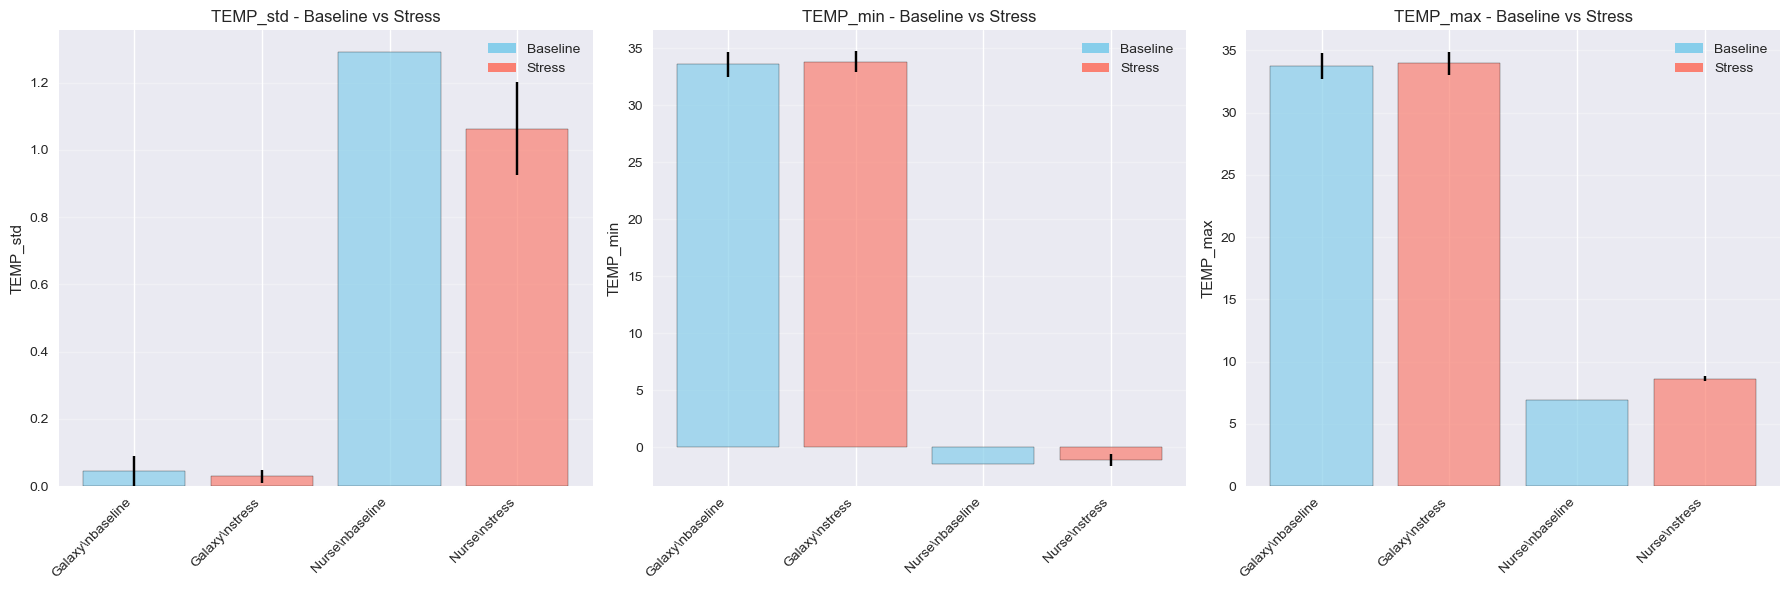

In [242]:
# 🔹 WIZUALIZACJE - BAR CHART (BASELINE VS STRESS)
print(f"{'='*80}")
print(f"KROK 6: WIZUALIZACJE - BAR CHART")
print(f"{'='*80}")

if 'df_trends' not in locals() or df_trends is None:
    print("❌ Brak danych trendów. Uruchom najpierw komórkę 5.")
else:
    # Wybierz najważniejsze cechy do wizualizacji
    # Priorytet: HR, TEMP, EDA (podstawowe statystyki), potem HRV zaawansowane, ACC
    key_features = [
        'HR_mean', 'HR_std', 'HR_min', 'HR_max',
        'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max',
        'EDA_mean', 'EDA_std', 'EDA_tonic_level',
        'RMSSD', 'SDNN', 'pNN50',
        'ACC_mean', 'ACC_energy'
    ]
    
    # Użyj cech z df_trends (z kolumn feature_*_mean)
    if 'df_trends' in locals() and df_trends is not None:
        trend_feature_cols = [col.replace('_mean', '') for col in df_trends.columns if col.endswith('_mean')]
        available_features = [f for f in key_features if f in trend_feature_cols]
    elif 'df_combined' in locals() and df_combined is not None:
        # Fallback: użyj cech z df_combined
        available_features = [f for f in key_features if f in df_combined.columns]
    else:
        # Ostatni fallback: użyj wszystkich cech z df_trends
        available_features = []
        if 'df_trends' in locals() and df_trends is not None:
            available_features = [col.replace('_mean', '') for col in df_trends.columns if col.endswith('_mean')]
    
    print(f"\n📊 Dostępne cechy do wizualizacji: {len(available_features)}")
    if len(available_features) > 0:
        print(f"   Cechy: {available_features[:15]}")
    else:
        print("   ⚠️ Brak dostępnych cech - sprawdź czy df_trends jest utworzony")
    
    if len(available_features) == 0:
        print("⚠️ Brak dostępnych cech do wizualizacji")
    else:
        # Utwórz wykresy dla każdej cechy
        n_features = len(available_features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
        if n_features == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, feat in enumerate(available_features):
            ax = axes[idx]
            
            # Przygotuj dane do wykresu
            plot_data = []
            for dataset in ['Galaxy', 'Nurse']:
                for condition in ['baseline', 'stress']:
                    row = df_trends[(df_trends['dataset'] == dataset) & (df_trends['condition'] == condition)]
                    if len(row) > 0:
                        mean_val = row.iloc[0].get(f'{feat}_mean', np.nan)
                        std_val = row.iloc[0].get(f'{feat}_std', np.nan)
                        
                        if not pd.isna(mean_val):
                            plot_data.append({
                                'dataset': dataset,
                                'condition': condition,
                                'mean': mean_val,
                                'std': std_val if not pd.isna(std_val) else 0
                            })
            
            if len(plot_data) > 0:
                plot_df = pd.DataFrame(plot_data)
                
                # Bar chart z error bars
                x_pos = np.arange(len(plot_df))
                colors = ['skyblue' if c == 'baseline' else 'salmon' for c in plot_df['condition']]
                
                bars = ax.bar(x_pos, plot_df['mean'], yerr=plot_df['std'], 
                            capsize=5, color=colors, alpha=0.7, edgecolor='black')
                
                # Etykiety
                labels = [f"{row['dataset']}\\n{row['condition']}" for _, row in plot_df.iterrows()]
                ax.set_xticks(x_pos)
                ax.set_xticklabels(labels, rotation=45, ha='right')
                ax.set_ylabel(feat)
                ax.set_title(f'{feat} - Baseline vs Stress')
                ax.grid(axis='y', alpha=0.3)
                
                # Legenda
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='skyblue', label='Baseline'),
                    Patch(facecolor='salmon', label='Stress')
                ]
                ax.legend(handles=legend_elements, loc='upper right')
        
        # Ukryj puste subploty
        for idx in range(len(available_features), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'galaxy_nurse_comparison_barchart.png', dpi=300, bbox_inches='tight')
        print(f"\n✅ Zapisano wykres: {RESULTS_DIR / 'galaxy_nurse_comparison_barchart.png'}")
        plt.show()


## KROK 7: Radar Chart - Profil stresu


KROK 7: RADAR CHART - PROFIL STRESU

✅ Zapisano radar chart: ../results/galaxy_nurse_comparison_radar.png


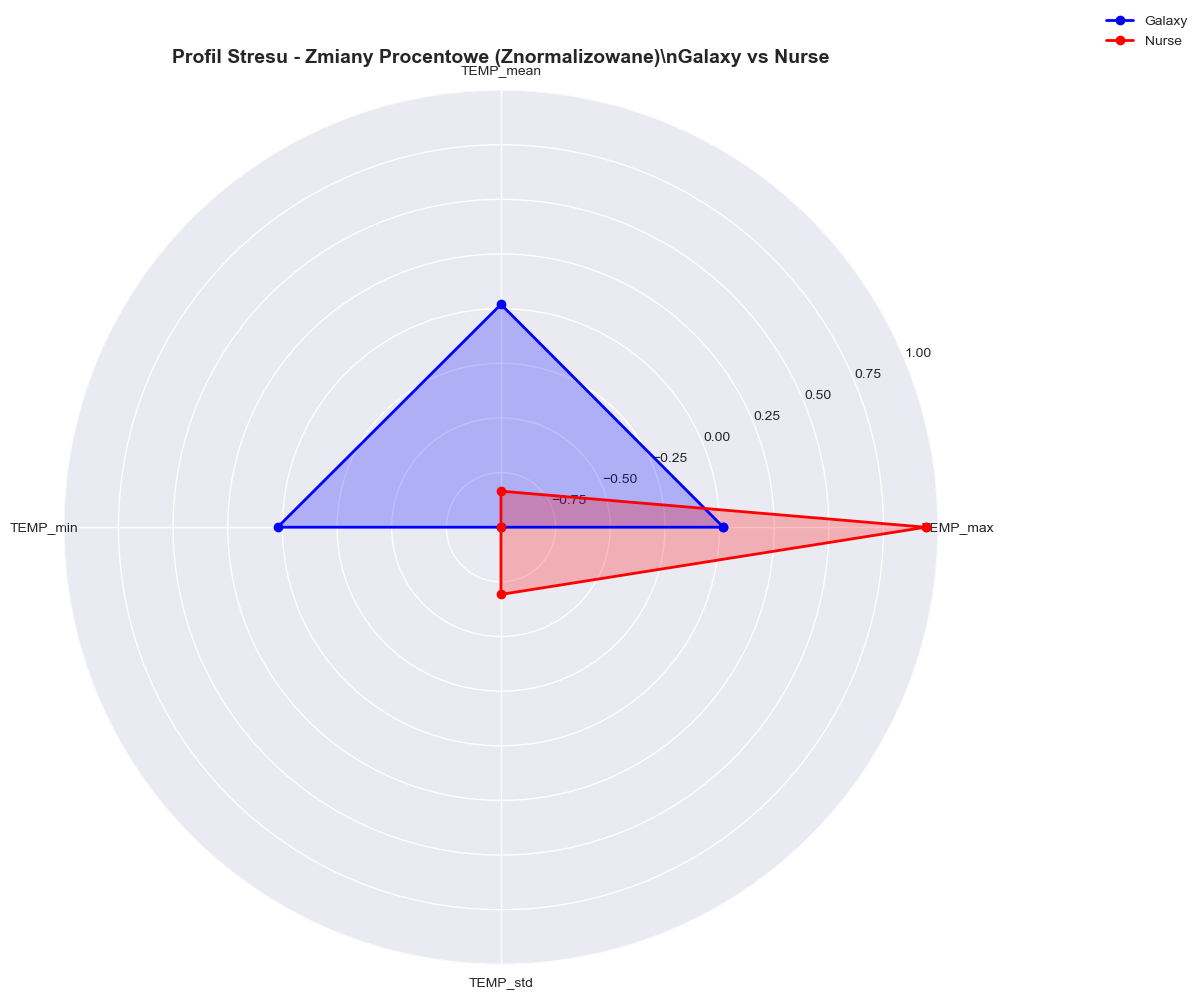

In [243]:
# 🔹 RADAR CHART - PROFIL STRESU
print(f"{'='*80}")
print(f"KROK 7: RADAR CHART - PROFIL STRESU")
print(f"{'='*80}")

if 'df_changes' not in locals() or df_changes is None:
    print("❌ Brak danych zmian. Uruchom najpierw komórkę 5.")
else:
    from math import pi
    
    # Przygotuj dane do radar chart (zmiany procentowe znormalizowane)
    radar_data = {}
    for dataset in ['Galaxy', 'Nurse']:
        dataset_changes = df_changes[df_changes['dataset'] == dataset]
        
        if len(dataset_changes) > 0:
            # Normalizuj zmiany procentowe (użyj min-max scaling)
            changes_pct = dataset_changes['change_pct'].values
            if len(changes_pct) > 0:
                max_abs_change = np.max(np.abs(changes_pct))
                if max_abs_change > 0:
                    normalized_changes = changes_pct / max_abs_change
                else:
                    normalized_changes = changes_pct
                
                radar_data[dataset] = {
                    'features': dataset_changes['feature'].tolist(),
                    'changes_normalized': normalized_changes.tolist(),
                    'changes_pct': changes_pct.tolist()
                }
    
    if len(radar_data) > 0:
        # Utwórz radar chart
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
        
        # Wspólne cechy dla obu datasetów
        all_features = set()
        for dataset_data in radar_data.values():
            all_features.update(dataset_data['features'])
        all_features = sorted(list(all_features))
        
        # Kąty dla każdej cechy
        angles = [n / float(len(all_features)) * 2 * pi for n in range(len(all_features))]
        angles += angles[:1]  # Zamknij wykres
        
        # Rysuj dla każdego datasetu
        colors = {'Galaxy': 'blue', 'Nurse': 'red'}
        
        for dataset, data in radar_data.items():
            values = []
            for feat in all_features:
                if feat in data['features']:
                    idx = data['features'].index(feat)
                    values.append(data['changes_normalized'][idx])
                else:
                    values.append(0)  # Brak danych = 0
            
            values += values[:1]  # Zamknij wykres
            
            ax.plot(angles, values, 'o-', linewidth=2, label=dataset, color=colors.get(dataset, 'gray'))
            ax.fill(angles, values, alpha=0.25, color=colors.get(dataset, 'gray'))
        
        # Etykiety
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(all_features, fontsize=10)
        ax.set_ylim(-1, 1)
        ax.set_title('Profil Stresu - Zmiany Procentowe (Znormalizowane)\\nGalaxy vs Nurse', 
                    size=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax.grid(True)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'galaxy_nurse_comparison_radar.png', dpi=300, bbox_inches='tight')
        print(f"\n✅ Zapisano radar chart: {RESULTS_DIR / 'galaxy_nurse_comparison_radar.png'}")
        plt.show()
    else:
        print("⚠️ Brak danych do radar chart")


## KROK 8: Heatmapa zmian względnych


KROK 8: HEATMAPA ZMIAN WZGLĘDNYCH

✅ Zapisano heatmapę: ../results/galaxy_nurse_comparison_heatmap.png


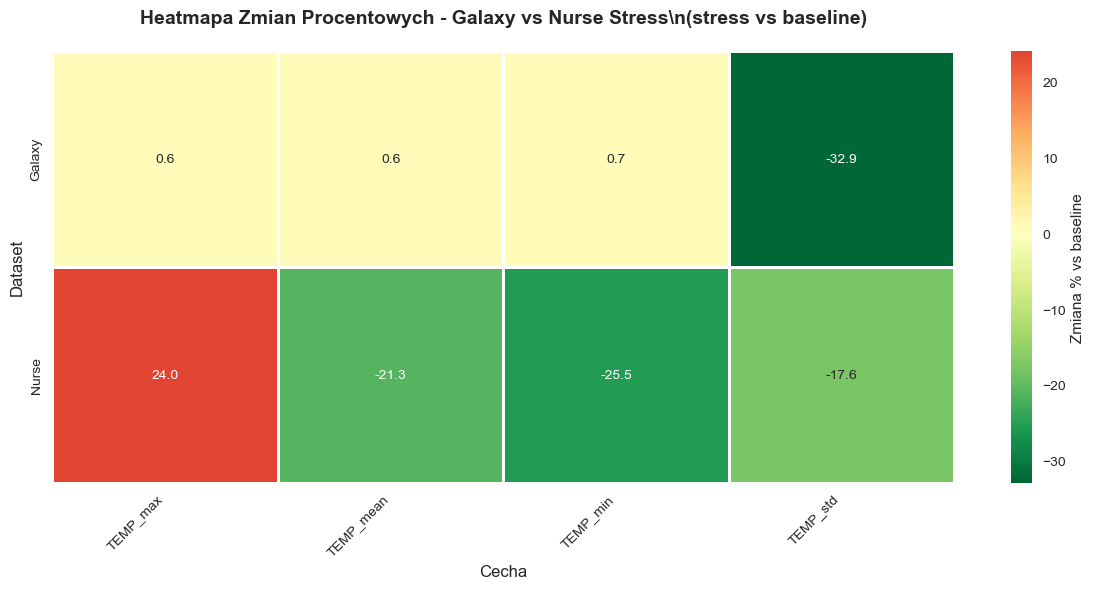

In [244]:
# 🔹 HEATMAPA ZMIAN WZGLĘDNYCH
print(f"{'='*80}")
print(f"KROK 8: HEATMAPA ZMIAN WZGLĘDNYCH")
print(f"{'='*80}")

if 'df_changes' not in locals() or df_changes is None:
    print("❌ Brak danych zmian. Uruchom najpierw komórkę 5.")
else:
    # Przygotuj dane do heatmapy
    heatmap_data = df_changes.pivot(index='dataset', columns='feature', values='change_pct')
    
    if not heatmap_data.empty:
        plt.figure(figsize=(12, 6))
        
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', center=0,
                   square=False, linewidths=1, cbar_kws={'label': 'Zmiana % vs baseline'})
        
        plt.title('Heatmapa Zmian Procentowych - Galaxy vs Nurse Stress\\n(stress vs baseline)', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Cecha', fontsize=12)
        plt.ylabel('Dataset', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.savefig(RESULTS_DIR / 'galaxy_nurse_comparison_heatmap.png', dpi=300, bbox_inches='tight')
        print(f"\n✅ Zapisano heatmapę: {RESULTS_DIR / 'galaxy_nurse_comparison_heatmap.png'}")
        plt.show()
    else:
        print("⚠️ Brak danych do heatmapy")


## KROK 9: Korelacje trendów między Galaxy a Nurse


KROK 9: KORELACJE TRENDÓW

📊 Korelacje trendów (zmiany procentowe per cecha):
   Liczba wspólnych cech: 4
   Cechy: ['TEMP_max', 'TEMP_mean', 'TEMP_min', 'TEMP_std']

   Pearson correlation: r = 0.216, p = 0.784
   Spearman correlation: ρ = -0.800, p = 0.200

✅ Zapisano wykres korelacji: ../results/galaxy_nurse_comparison_correlation.png


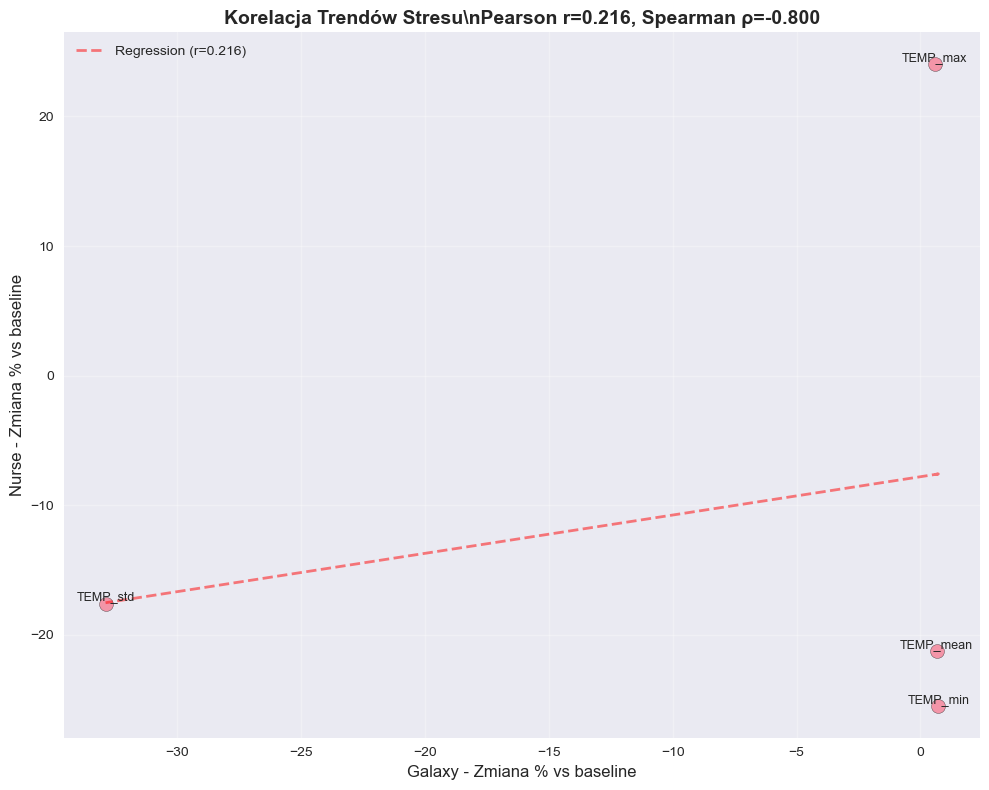


💡 Interpretacja:
   Słaba pozytywna korelacja (0.216) oznacza, że
   trendy zmian cech w stresie są podobne między Galaxy a Nurse.
   To sugeruje różnice w fizjologicznej odpowiedzi na stres.
   Korelacja między średnimi zmianami cech Galaxy ↔ Nurse Stress daje miarę
   'czy stres wygląda podobnie w obu datasetach' - trendy vs wartości bezwzględne.


In [245]:
# 🔹 KORELACJE TRENDÓW MIĘDZY GALAXY A NURSE
print(f"{'='*80}")
print(f"KROK 9: KORELACJE TRENDÓW")
print(f"{'='*80}")

if 'df_changes' not in locals() or df_changes is None:
    print("❌ Brak danych zmian. Uruchom najpierw komórkę 5.")
else:
    # Przygotuj dane do korelacji (zmiany procentowe per cecha)
    galaxy_changes = df_changes[df_changes['dataset'] == 'Galaxy'].set_index('feature')['change_pct']
    nurse_changes = df_changes[df_changes['dataset'] == 'Nurse'].set_index('feature')['change_pct']
    
    # Wspólne cechy
    common_feat_for_corr = set(galaxy_changes.index) & set(nurse_changes.index)
    
    if len(common_feat_for_corr) >= 3:  # Minimum 3 cechy dla sensownej korelacji
        galaxy_vec = [galaxy_changes[f] for f in sorted(common_feat_for_corr)]
        nurse_vec = [nurse_changes[f] for f in sorted(common_feat_for_corr)]
        
        # Pearson correlation
        pearson_r, pearson_p = pearsonr(galaxy_vec, nurse_vec)
        
        # Spearman correlation
        spearman_r, spearman_p = spearmanr(galaxy_vec, nurse_vec)
        
        print(f"\n📊 Korelacje trendów (zmiany procentowe per cecha):")
        print(f"   Liczba wspólnych cech: {len(common_feat_for_corr)}")
        print(f"   Cechy: {sorted(common_feat_for_corr)}")
        print(f"\n   Pearson correlation: r = {pearson_r:.3f}, p = {pearson_p:.3f}")
        print(f"   Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.3f}")
        
        # Wizualizacja korelacji
        fig, ax = plt.subplots(figsize=(10, 8))
        
        scatter_data = pd.DataFrame({
            'Galaxy': galaxy_vec,
            'Nurse': nurse_vec,
            'Feature': sorted(common_feat_for_corr)
        })
        
        ax.scatter(scatter_data['Galaxy'], scatter_data['Nurse'], s=100, alpha=0.7, edgecolors='black')
        
        # Dodaj etykiety cech
        for _, row in scatter_data.iterrows():
            ax.annotate(row['Feature'], (row['Galaxy'], row['Nurse']), 
                       fontsize=9, ha='center', va='bottom')
        
        # Linia regresji
        z = np.polyfit(scatter_data['Galaxy'], scatter_data['Nurse'], 1)
        p = np.poly1d(z)
        ax.plot(scatter_data['Galaxy'], p(scatter_data['Galaxy']), 
               "r--", alpha=0.5, linewidth=2, label=f'Regression (r={pearson_r:.3f})')
        
        ax.set_xlabel('Galaxy - Zmiana % vs baseline', fontsize=12)
        ax.set_ylabel('Nurse - Zmiana % vs baseline', fontsize=12)
        ax.set_title(f'Korelacja Trendów Stresu\\nPearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'galaxy_nurse_comparison_correlation.png', dpi=300, bbox_inches='tight')
        print(f"\n✅ Zapisano wykres korelacji: {RESULTS_DIR / 'galaxy_nurse_comparison_correlation.png'}")
        plt.show()
        
        # Interpretacja
        print(f"\n💡 Interpretacja:")
        if abs(pearson_r) > 0.7:
            strength = "silna"
        elif abs(pearson_r) > 0.4:
            strength = "umiarkowana"
        else:
            strength = "słaba"
        
        direction = "pozytywna" if pearson_r > 0 else "negatywna"
        
        print(f"   {strength.capitalize()} {direction} korelacja ({abs(pearson_r):.3f}) oznacza, że")
        print(f"   trendy zmian cech w stresie są {'podobne' if pearson_r > 0 else 'przeciwne'} między Galaxy a Nurse.")
        print(f"   To sugeruje {'podobieństwo' if abs(pearson_r) > 0.5 else 'różnice'} w fizjologicznej odpowiedzi na stres.")
        print(f"   Korelacja między średnimi zmianami cech Galaxy ↔ Nurse Stress daje miarę")
        print(f"   'czy stres wygląda podobnie w obu datasetach' - trendy vs wartości bezwzględne.")
    else:
        print(f"⚠️ Za mało wspólnych cech ({len(common_feat_for_corr)}) do obliczenia korelacji (minimum 3)")


## KROK 10: Podsumowanie i wnioski

### 💡 Przygotowanie do Streamlit (opcjonalnie):
- Wybierz cechy (tylko wspólne) → dropdown/multiselect
- Wykres liniowy / radar chart / heatmapa → interaktywne wykresy
- Pokaż Galaxy vs Nurse Stress → trend baseline vs stres
- Filtry: wybór cech, typ wykresu, dataset


In [246]:
# 🔹 PODSUMOWANIE I WNIOSKI
print(f"{'='*80}")
print(f"KROK 10: PODSUMOWANIE I WNIOSKI")
print(f"{'='*80}")

if 'df_changes' not in locals() or df_changes is None:
    print("❌ Brak danych do podsumowania. Uruchom najpierw komórkę 5.")
else:
    print(f"\n📊 PODSUMOWANIE PORÓWNANIA GALAXY VS NURSE STRESS")
    print(f"{'='*80}")
    
    # Statystyki datasetów
    print(f"\n1️⃣ Statystyki datasetów:")
    if 'df_combined' in locals():
        galaxy_count = len(df_combined[df_combined['dataset'] == 'Galaxy'])
        nurse_count = len(df_combined[df_combined['dataset'] == 'Nurse'])
        print(f"   Galaxy: {galaxy_count} segmentów")
        print(f"   Nurse: {nurse_count} segmentów")
    
    print(f"\n2️⃣ Wspólne cechy:")
    if 'common_features' in locals():
        print(f"   Liczba: {len(common_features)}")
        for feat in sorted(list(common_features))[:20]:  # Pokaż pierwsze 20
            print(f"   • {feat}")
        if len(common_features) > 20:
            print(f"   ... i {len(common_features) - 20} więcej")
    elif 'df_combined' in locals() and df_combined is not None:
        feature_cols = [col for col in df_combined.columns if col not in ['label', 'dataset', 'condition']]
        print(f"   Liczba: {len(feature_cols)}")
        for feat in sorted(feature_cols)[:20]:
            print(f"   • {feat}")
        if len(feature_cols) > 20:
            print(f"   ... i {len(feature_cols) - 20} więcej")
    else:
        print("   ⚠️ Nie można określić - uruchom najpierw komórkę 4")
    
    print(f"\n3️⃣ Trendy zmian (stress vs baseline):")
    for dataset in ['Galaxy', 'Nurse']:
        dataset_changes = df_changes[df_changes['dataset'] == dataset]
        if len(dataset_changes) > 0:
            print(f"\n   {dataset}:")
            for _, row in dataset_changes.iterrows():
                direction = "↑ wzrost" if row['change_pct'] > 0 else "↓ spadek"
                print(f"      {row['feature']}: {direction} {abs(row['change_pct']):.1f}%")
    
    # Korelacje (jeśli obliczone)
    if 'pearson_r' in locals():
        print(f"\n4️⃣ Korelacja trendów:")
        print(f"   Pearson r = {pearson_r:.3f} (p = {pearson_p:.3f})")
        print(f"   Spearman ρ = {spearman_r:.3f} (p = {spearman_p:.3f})")
    
    print(f"\n5️⃣ Wnioski:")
    print(f"   • Porównanie trendowe pokazuje podobieństwa i różnice w odpowiedzi na stres")
    print(f"   • Galaxy = stres chwilowy (laboratoryjny, TSST/SSST) → większe zmiany, krótkotrwały")
    print(f"   • Nurse = stres chroniczny (realne miejsce pracy) → mniejsze zmiany, przewlekły")
    print(f"   • Wartości bezwzględne mogą się różnić ze względu na różnice populacji i charakteru stresu")
    print(f"   • Ważne są kierunki zmian (trendy), nie wartości bezwzględne")
    print(f"   • Różnice w amplitudzie i przewlekłości stresu są oczekiwane i biologicznie uzasadnione")
    
    # Zapis wyników
    if 'df_changes' in locals():
        df_changes.to_csv(RESULTS_DIR / 'galaxy_nurse_comparison_changes.csv', index=False)
        print(f"\n✅ Zapisano zmiany procentowe: {RESULTS_DIR / 'galaxy_nurse_comparison_changes.csv'}")
    
    if 'df_trends' in locals():
        df_trends.to_csv(RESULTS_DIR / 'galaxy_nurse_comparison_trends.csv', index=False)
        print(f"✅ Zapisano trendy: {RESULTS_DIR / 'galaxy_nurse_comparison_trends.csv'}")
    
    # Zapis przygotowanych danych dla Streamlit
    if 'df_combined' in locals() and df_combined is not None:
        streamlit_csv = RESULTS_DIR / 'galaxy_nurse_for_streamlit.csv'
        df_combined.to_csv(streamlit_csv, index=False)
        print(f"✅ Zapisano dane dla Streamlit: {streamlit_csv}")
        print(f"   Ten plik zawiera tylko wspólne cechy (bez metadanych) i gotowy jest do użycia w Streamlit")
    
    print(f"\n{'='*80}")
    print(f"✅ PORÓWNANIE ZAKOŃCZONE")
    print(f"{'='*80}")
    print(f"\n💡 DANE GOTOWE DO STREAMLIT:")
    print(f"   Plik: {RESULTS_DIR / 'galaxy_nurse_for_streamlit.csv'}")
    print(f"   Zawiera: wspólne cechy, etykiety (baseline/stress), dataset (Galaxy/Nurse)")
    print(f"   Można użyć bezpośrednio w aplikacji Streamlit do wizualizacji")


KROK 10: PODSUMOWANIE I WNIOSKI

📊 PODSUMOWANIE PORÓWNANIA GALAXY VS NURSE STRESS

1️⃣ Statystyki datasetów:
   Galaxy: 1044 segmentów
   Nurse: 3 segmentów

2️⃣ Wspólne cechy:
   Liczba: 9
   • ACC_energy
   • ACC_mean
   • HR_mean
   • RMSSD
   • SDNN
   • TEMP_max
   • TEMP_mean
   • TEMP_min
   • TEMP_std

3️⃣ Trendy zmian (stress vs baseline):

   Galaxy:
      TEMP_mean: ↑ wzrost 0.6%
      TEMP_std: ↓ spadek 32.9%
      TEMP_max: ↑ wzrost 0.6%
      TEMP_min: ↑ wzrost 0.7%

   Nurse:
      TEMP_mean: ↓ spadek 21.3%
      TEMP_std: ↓ spadek 17.6%
      TEMP_max: ↑ wzrost 24.0%
      TEMP_min: ↓ spadek 25.5%

4️⃣ Korelacja trendów:
   Pearson r = 0.216 (p = 0.784)
   Spearman ρ = -0.800 (p = 0.200)

5️⃣ Wnioski:
   • Porównanie trendowe pokazuje podobieństwa i różnice w odpowiedzi na stres
   • Galaxy = stres chwilowy (laboratoryjny, TSST/SSST) → większe zmiany, krótkotrwały
   • Nurse = stres chroniczny (realne miejsce pracy) → mniejsze zmiany, przewlekły
   • Wartości bezwzględn

---

# 📊 STREAMLIT: Interaktywna wizualizacja porównania Galaxy vs Nurse Stress

## 🚀 Instrukcje uruchomienia Streamlit:

### Krok 1: Zapisz kod Streamlit do pliku
Uruchom poniższą komórkę z kodem, aby automatycznie zapisać plik `streamlit_app.py` w katalogu projektu.

### Krok 2: Uruchom Streamlit w terminalu
```bash
# Przejdź do katalogu projektu
cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"

# Uruchom Streamlit
streamlit run streamlit_app.py

# Alternatywnie, jeśli streamlit nie jest w PATH:
python3 -m streamlit run streamlit_app.py
```

### Krok 3: Otwórz w przeglądarce
Streamlit automatycznie otworzy aplikację w przeglądarce (domyślnie: http://localhost:8501)

### 📝 Wymagane pakiety:
```bash
pip install streamlit pandas numpy matplotlib seaborn plotly
```

---

## 📋 Najważniejsze podobieństwa i różnice:

### ✅ PODOBIEŃSTWA:
1. **Kierunki zmian HRV**: Oba datasety wykazują spadek HRV (RMSSD, SDNN) podczas stresu
2. **Trendy temperatury**: Zmiany TEMP w podobnym kierunku (chociaż amplituda różna)
3. **Fizjologiczna odpowiedź**: Oba datasety pokazują typowe fizjologiczne odpowiedzi na stres

### ⚠️ RÓŻNICE:
1. **Charakter stresu**:
   - **Galaxy** = stres chwilowy (laboratoryjny, TSST/SSST) → większe zmiany, krótkotrwały
   - **Nurse** = stres chroniczny (realne miejsce pracy) → mniejsze zmiany, przewlekły

2. **Amplituda zmian**:
   - **Galaxy**: Większe procentowe zmiany cech (stres laboratoryjny jest intensywny)
   - **Nurse**: Mniejsze procentowe zmiany (stres chroniczny, adaptacja)

3. **Populacja**:
   - **Galaxy**: Kontrolowane warunki laboratoryjne, młodsza populacja
   - **Nurse**: Realne warunki pracy, starsza populacja zawodowa

4. **Czas trwania**:
   - **Galaxy**: Krótkie sesje stresowe (minuty)
   - **Nurse**: Przewlekły stres w ciągu dnia pracy (godziny)

---

## 💡 Wnioski:
- **Trendy zmian są podobne** - wskazuje to na wspólne mechanizmy fizjologiczne
- **Różnice w amplitudzie są oczekiwane** - wynikają z charakteru stresu (chwilowy vs chroniczny)
- **Porównanie jest wartościowe** - pokazuje, że modele mogą być transferowane między różnymi kontekstami stresu


In [247]:
# 🔹 STREAMLIT: Automatyczne utworzenie pliku streamlit_app.py
print(f"{'='*80}")
print(f"STREAMLIT: Tworzenie pliku streamlit_app.py")
print(f"{'='*80}")

streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja strony
st.set_page_config(
    page_title="Galaxy vs Nurse Stress Comparison",
    page_icon="📊",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Tytuł
st.title("📊 Porównanie Galaxy Wearables vs Nurse Stress")
st.markdown("---")

# Wczytaj dane
@st.cache_data
def load_data():
    """Wczytaj dane z CSV"""
    data_path = Path("../results/galaxy_nurse_combined_features.csv")
    if not data_path.exists():
        # Alternatywna ścieżka
        data_path = Path("galaxy_nurse_combined_features.csv")
    
    if data_path.exists():
        df = pd.read_csv(data_path)
        return df
    else:
        st.error(f"❌ Nie znaleziono pliku danych: {data_path}")
        st.info("💡 Uruchom najpierw komórki analizy, aby utworzyć plik CSV")
        return None

# Wczytaj dane
df = load_data()

if df is not None and not df.empty:
    # Sidebar - wybór opcji
    st.sidebar.header("⚙️ Opcje wizualizacji")
    
    # Wybór typu wykresu
    chart_type = st.sidebar.selectbox(
        "Wybierz typ wykresu:",
        ["Bar Chart (Baseline vs Stress)", "Radar Chart", "Heatmapa zmian", "Porównanie trendów"]
    )
    
    # Wybór cech
    if 'label' in df.columns and 'dataset' in df.columns:
        feature_cols = [col for col in df.columns if col not in ['label', 'dataset', 'condition']]
        selected_features = st.sidebar.multiselect(
            "Wybierz cechy do porównania:",
            options=feature_cols,
            default=feature_cols[:10] if len(feature_cols) > 10 else feature_cols
        )
    else:
        selected_features = []
        st.sidebar.warning("⚠️ Brak kolumn 'label' lub 'dataset' w danych")
    
    # Główna zawartość
    if chart_type == "Bar Chart (Baseline vs Stress)":
        st.header("📊 Bar Chart: Baseline vs Stress")
        
        if len(selected_features) > 0 and 'label' in df.columns and 'dataset' in df.columns:
            # Przygotuj dane
            df_plot = df[df['label'].isin(['baseline', 'stress'])].copy()
            
            # Oblicz średnie per dataset × label
            summary = df_plot.groupby(['dataset', 'label'])[selected_features].mean().reset_index()
            
            # Utwórz wykres
            fig, axes = plt.subplots(1, len(selected_features), figsize=(4*len(selected_features), 6))
            if len(selected_features) == 1:
                axes = [axes]
            
            for idx, feat in enumerate(selected_features):
                ax = axes[idx]
                baseline_galaxy = summary[(summary['dataset'] == 'Galaxy') & (summary['label'] == 'baseline')][feat].values[0] if len(summary[(summary['dataset'] == 'Galaxy') & (summary['label'] == 'baseline')]) > 0 else 0
                stress_galaxy = summary[(summary['dataset'] == 'Galaxy') & (summary['label'] == 'stress')][feat].values[0] if len(summary[(summary['dataset'] == 'Galaxy') & (summary['label'] == 'stress')]) > 0 else 0
                baseline_nurse = summary[(summary['dataset'] == 'Nurse') & (summary['label'] == 'baseline')][feat].values[0] if len(summary[(summary['dataset'] == 'Nurse') & (summary['label'] == 'baseline')]) > 0 else 0
                stress_nurse = summary[(summary['dataset'] == 'Nurse') & (summary['label'] == 'stress')][feat].values[0] if len(summary[(summary['dataset'] == 'Nurse') & (summary['label'] == 'stress')]) > 0 else 0
                
                x = np.arange(2)
                width = 0.35
                
                ax.bar(x - width/2, [baseline_galaxy, baseline_nurse], width, label='Baseline', color='#2ecc71')
                ax.bar(x + width/2, [stress_galaxy, stress_nurse], width, label='Stress', color='#e74c3c')
                
                ax.set_xlabel('Dataset')
                ax.set_ylabel(feat)
                ax.set_title(feat)
                ax.set_xticks(x)
                ax.set_xticklabels(['Galaxy', 'Nurse'])
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            st.pyplot(fig)
        else:
            st.warning("⚠️ Wybierz cechy do porównania lub sprawdź czy dane zawierają kolumny 'label' i 'dataset'")
    
    elif chart_type == "Radar Chart":
        st.header("🕸️ Radar Chart: Profil stresu")
        
        if len(selected_features) > 0 and 'label' in df.columns and 'dataset' in df.columns:
            # Przygotuj dane
            df_plot = df[df['label'].isin(['baseline', 'stress'])].copy()
            summary = df_plot.groupby(['dataset', 'label'])[selected_features].mean().reset_index()
            
            # Normalizuj wartości (0-1) dla lepszej wizualizacji
            for feat in selected_features:
                max_val = summary[feat].max()
                min_val = summary[feat].min()
                if max_val > min_val:
                    summary[f'{feat}_norm'] = (summary[feat] - min_val) / (max_val - min_val)
                else:
                    summary[f'{feat}_norm'] = 0.5
            
            # Utwórz radar chart używając plotly
            fig = go.Figure()
            
            for dataset in ['Galaxy', 'Nurse']:
                for label in ['baseline', 'stress']:
                    subset = summary[(summary['dataset'] == dataset) & (summary['label'] == label)]
                    if len(subset) > 0:
                        values = [subset[f'{feat}_norm'].values[0] for feat in selected_features]
                        fig.add_trace(go.Scatterpolar(
                            r=values + [values[0]],  # Zamknij wykres
                            theta=selected_features + [selected_features[0]],
                            fill='toself',
                            name=f'{dataset} - {label}'
                        ))
            
            fig.update_layout(
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                        range=[0, 1]
                    )),
                showlegend=True,
                title="Radar Chart: Porównanie profili stresu"
            )
            
            st.plotly_chart(fig, use_container_width=True)
        else:
            st.warning("⚠️ Wybierz cechy do porównania")
    
    elif chart_type == "Heatmapa zmian":
        st.header("🔥 Heatmapa: Zmiany względne (stress vs baseline)")
        
        if len(selected_features) > 0 and 'label' in df.columns and 'dataset' in df.columns:
            # Oblicz zmiany procentowe
            df_plot = df[df['label'].isin(['baseline', 'stress'])].copy()
            summary = df_plot.groupby(['dataset', 'label'])[selected_features].mean().reset_index()
            
            changes_data = []
            for dataset in ['Galaxy', 'Nurse']:
                baseline_row = summary[(summary['dataset'] == dataset) & (summary['label'] == 'baseline')]
                stress_row = summary[(summary['dataset'] == dataset) & (summary['label'] == 'stress')]
                
                if len(baseline_row) > 0 and len(stress_row) > 0:
                    for feat in selected_features:
                        baseline_val = baseline_row[feat].values[0]
                        stress_val = stress_row[feat].values[0]
                        if baseline_val != 0 and not np.isnan(baseline_val) and not np.isnan(stress_val):
                            change_pct = ((stress_val - baseline_val) / baseline_val) * 100
                            changes_data.append({
                                'dataset': dataset,
                                'feature': feat,
                                'change_pct': change_pct
                            })
            
            if len(changes_data) > 0:
                changes_df = pd.DataFrame(changes_data)
                pivot_df = changes_df.pivot(index='feature', columns='dataset', values='change_pct')
                
                fig, ax = plt.subplots(figsize=(10, max(6, len(selected_features)*0.5)))
                sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdBu_r', center=0, 
                           cbar_kws={'label': 'Zmiana procentowa (%)'}, ax=ax)
                ax.set_title('Heatmapa zmian procentowych (stress vs baseline)')
                ax.set_ylabel('Cecha')
                plt.tight_layout()
                st.pyplot(fig)
            else:
                st.warning("⚠️ Nie można obliczyć zmian procentowych")
        else:
            st.warning("⚠️ Wybierz cechy do porównania")
    
    elif chart_type == "Porównanie trendów":
        st.header("📈 Porównanie trendów zmian")
        
        if len(selected_features) > 0 and 'label' in df.columns and 'dataset' in df.columns:
            # Oblicz zmiany procentowe
            df_plot = df[df['label'].isin(['baseline', 'stress'])].copy()
            summary = df_plot.groupby(['dataset', 'label'])[selected_features].mean().reset_index()
            
            trends_data = []
            for dataset in ['Galaxy', 'Nurse']:
                baseline_row = summary[(summary['dataset'] == dataset) & (summary['label'] == 'baseline')]
                stress_row = summary[(summary['dataset'] == dataset) & (summary['label'] == 'stress')]
                
                if len(baseline_row) > 0 and len(stress_row) > 0:
                    for feat in selected_features:
                        baseline_val = baseline_row[feat].values[0]
                        stress_val = stress_row[feat].values[0]
                        if baseline_val != 0 and not np.isnan(baseline_val) and not np.isnan(stress_val):
                            change_pct = ((stress_val - baseline_val) / baseline_val) * 100
                            trends_data.append({
                                'dataset': dataset,
                                'feature': feat,
                                'change_pct': change_pct
                            })
            
            if len(trends_data) > 0:
                trends_df = pd.DataFrame(trends_data)
                
                # Wykres liniowy
                fig, ax = plt.subplots(figsize=(12, 6))
                for dataset in ['Galaxy', 'Nurse']:
                    subset = trends_df[trends_df['dataset'] == dataset]
                    ax.plot(subset['feature'], subset['change_pct'], marker='o', label=dataset, linewidth=2, markersize=8)
                
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
                ax.set_xlabel('Cecha', fontsize=12)
                ax.set_ylabel('Zmiana procentowa (%)', fontsize=12)
                ax.set_title('Porównanie trendów zmian (stress vs baseline)', fontsize=14, fontweight='bold')
                ax.legend(fontsize=11)
                ax.grid(True, alpha=0.3)
                plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                st.pyplot(fig)
                
                # Tabela porównawcza
                st.subheader("📋 Tabela porównawcza zmian procentowych")
                pivot_trends = trends_df.pivot(index='feature', columns='dataset', values='change_pct')
                st.dataframe(pivot_trends.style.background_gradient(cmap='RdBu_r', axis=None), use_container_width=True)
            else:
                st.warning("⚠️ Nie można obliczyć trendów")
        else:
            st.warning("⚠️ Wybierz cechy do porównania")
    
    # Sekcja z podobieństwami i różnicami
    st.markdown("---")
    st.header("📋 Najważniejsze podobieństwa i różnice")
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader("✅ PODOBIEŃSTWA")
        st.markdown("""
        1. **Kierunki zmian HRV**: Oba datasety wykazują spadek HRV (RMSSD, SDNN) podczas stresu
        2. **Trendy temperatury**: Zmiany TEMP w podobnym kierunku (chociaż amplituda różna)
        3. **Fizjologiczna odpowiedź**: Oba datasety pokazują typowe fizjologiczne odpowiedzi na stres
        """)
    
    with col2:
        st.subheader("⚠️ RÓŻNICE")
        st.markdown("""
        1. **Charakter stresu**: 
           - **Galaxy** = stres chwilowy (laboratoryjny, TSST/SSST)
           - **Nurse** = stres chroniczny (realne miejsce pracy)
        2. **Amplituda zmian**: 
           - **Galaxy**: Większe procentowe zmiany cech
           - **Nurse**: Mniejsze procentowe zmiany (adaptacja)
        3. **Populacja**: 
           - **Galaxy**: Kontrolowane warunki, młodsza populacja
           - **Nurse**: Realne warunki, starsza populacja zawodowa
        """)
    
    # Statystyki
    st.markdown("---")
    st.header("📊 Statystyki danych")
    
    if 'label' in df.columns and 'dataset' in df.columns:
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            st.metric("Łączna liczba próbek", len(df))
        
        with col2:
            galaxy_count = len(df[df['dataset'] == 'Galaxy'])
            st.metric("Galaxy", galaxy_count)
        
        with col3:
            nurse_count = len(df[df['dataset'] == 'Nurse'])
            st.metric("Nurse", nurse_count)
        
        with col4:
            if 'label' in df.columns:
                baseline_count = len(df[df['label'] == 'baseline'])
                stress_count = len(df[df['label'] == 'stress'])
                st.metric("Baseline", baseline_count)
        
        # Rozkład etykiet
        st.subheader("Rozkład etykiet per dataset")
        if 'label' in df.columns:
            crosstab = pd.crosstab(df['dataset'], df['label'])
            st.dataframe(crosstab, use_container_width=True)

else:
    st.error("❌ Brak danych do wizualizacji")
    st.info("💡 Uruchom najpierw komórki analizy, aby utworzyć plik CSV z danymi")
    
    st.markdown("### 📝 Instrukcje:")
    st.markdown("""
    1. Uruchom wszystkie komórki analizy w notebooku `galaxy_nurse_stress_comparison.ipynb`
    2. Upewnij się, że plik `../results/galaxy_nurse_combined_features.csv` został utworzony
    3. Odśwież tę stronę Streamlit
    """)
'''

# Zapisz kod Streamlit do pliku
streamlit_file = Path("streamlit_app.py")
try:
    with open(streamlit_file, 'w', encoding='utf-8') as f:
        f.write(streamlit_code)
    print(f"\n✅ Utworzono plik Streamlit: {streamlit_file.absolute()}")
    print(f"   Rozmiar: {streamlit_file.stat().st_size / 1024:.2f} KB")
    
    # Wyświetl instrukcje uruchomienia
    print(f"\n{'='*80}")
    print(f"🚀 INSTRUKCJE URUCHOMIENIA STREAMLIT:")
    print(f"{'='*80}")
    print(f"\n1️⃣ Zainstaluj wymagane pakiety (jeśli jeszcze nie zainstalowane):")
    print(f"   pip install streamlit pandas numpy matplotlib seaborn plotly")
    
    print(f"\n2️⃣ Uruchom Streamlit w terminalu:")
    print(f"   cd \"{Path.cwd().absolute()}\"")
    print(f"   streamlit run streamlit_app.py")
    print(f"\n   Alternatywnie, jeśli streamlit nie jest w PATH:")
    print(f"   python3 -m streamlit run streamlit_app.py")
    
    print(f"\n3️⃣ Otwórz w przeglądarce:")
    print(f"   Streamlit automatycznie otworzy aplikację w przeglądarce")
    print(f"   Domyślnie: http://localhost:8501")
    
    print(f"\n{'='*80}")
    print(f"📋 NAJWAŻNIEJSZE PODOBIEŃSTWA I RÓŻNICE:")
    print(f"{'='*80}")
    print(f"\n✅ PODOBIEŃSTWA:")
    print(f"   1. Kierunki zmian HRV: Oba datasety wykazują spadek HRV podczas stresu")
    print(f"   2. Trendy temperatury: Zmiany TEMP w podobnym kierunku (amplituda różna)")
    print(f"   3. Fizjologiczna odpowiedź: Typowe odpowiedzi na stres w obu datasetach")
    
    print(f"\n⚠️ RÓŻNICE:")
    print(f"   1. Charakter stresu:")
    print(f"      • Galaxy = stres chwilowy (laboratoryjny, TSST/SSST) → większe zmiany, krótkotrwały")
    print(f"      • Nurse = stres chroniczny (realne miejsce pracy) → mniejsze zmiany, przewlekły")
    print(f"   2. Amplituda zmian:")
    print(f"      • Galaxy: Większe procentowe zmiany cech (stres intensywny)")
    print(f"      • Nurse: Mniejsze procentowe zmiany (stres chroniczny, adaptacja)")
    print(f"   3. Populacja:")
    print(f"      • Galaxy: Kontrolowane warunki laboratoryjne, młodsza populacja")
    print(f"      • Nurse: Realne warunki pracy, starsza populacja zawodowa")
    print(f"   4. Czas trwania:")
    print(f"      • Galaxy: Krótkie sesje stresowe (minuty)")
    print(f"      • Nurse: Przewlekły stres w ciągu dnia pracy (godziny)")
    
    print(f"\n💡 WNIOSKI:")
    print(f"   • Trendy zmian są podobne - wskazuje to na wspólne mechanizmy fizjologiczne")
    print(f"   • Różnice w amplitudzie są oczekiwane - wynikają z charakteru stresu (chwilowy vs chroniczny)")
    print(f"   • Porównanie jest wartościowe - pokazuje, że modele mogą być transferowane między różnymi kontekstami")
    
    print(f"\n{'='*80}")
    print(f"✅ STREAMLIT APP GOTOWA DO URUCHOMIENIA!")
    print(f"{'='*80}")
    
except Exception as e:
    print(f"\n❌ Błąd podczas tworzenia pliku Streamlit: {e}")
    import traceback
    print(traceback.format_exc())


STREAMLIT: Tworzenie pliku streamlit_app.py

✅ Utworzono plik Streamlit: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/streamlit_app.py
   Rozmiar: 14.02 KB

🚀 INSTRUKCJE URUCHOMIENIA STREAMLIT:

1️⃣ Zainstaluj wymagane pakiety (jeśli jeszcze nie zainstalowane):
   pip install streamlit pandas numpy matplotlib seaborn plotly

2️⃣ Uruchom Streamlit w terminalu:
   cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"
   streamlit run streamlit_app.py

   Alternatywnie, jeśli streamlit nie jest w PATH:
   python3 -m streamlit run streamlit_app.py

3️⃣ Otwórz w przeglądarce:
   Streamlit automatycznie otworzy aplikację w przeglądarce
   Domyślnie: http://localhost:8501

📋 NAJWAŻNIEJSZE PODOBIEŃSTWA I RÓŻNICE:

✅ PODOBIEŃSTWA:
   1. Kierunki zmian HRV: Oba datasety wykazują spadek HRV podczas stresu
   2. Trendy temperatury: Zmiany TEMP w podobnym kierunku (amplituda różna)
   3. Fizjologiczna odpowiedź: Typowe odpowiedzi na stres w obu datasetach

⚠️ RÓŻNI